In [2]:
import sys
import os

import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import metrics

from itertools import chain, combinations


sns.set()

print(os.getcwd())


c:\Users\J C\Documents\GitHub\niclassify


In [3]:
# ----- Extra Configuration ----

N_TRIALS = 10  # number of trials for mean BA calculation

In [4]:
def get_data(filename):
    return pd.read_csv(filename)


In [5]:
def create_kmeans(x, k, weights=None):
    """Create list of cluster ID's using k-means clustering.

    Args:
        x (ndarray): Data to cluster.
        k (int): number of clusters to make

    Returns:
        array: cluster ID's

    """
    # kmeans = make_pipeline(
    #     StandardScaler().fit_transform(),
    #     KMeans(n_clusters=k)
    # )
    kmeans = KMeans(n_clusters=k)

    return kmeans.fit_predict(x, sample_weight=weights)

In [6]:
def get_predict(cluster, metadata_known, c_labels="Status"):
    """Get the predicted labels from cluster assignments and known labels.

    Args:
        cluster (Series): A series of cluster assignments.
        metadata_known (DataFrame): Metadata (including class labels) of known
            data.
        c_labels (str, optional): Name of column containing class labels.
            Defaults to "Status".

    Returns:
        [type]: [description]

    """
    matches = {}
    # loop over metadata rows
    # add number of matches to either cluster 0 or 1 per status label
    for index, row in metadata_known.iterrows():
        if row[c_labels] not in matches.keys():
            matches[row[c_labels]] = [0] * metadata_known[c_labels].nunique()
        matches[row[c_labels]][cluster[index]] += 1

    # convert frequencies to proportions
    for key, val in matches.copy().items():
        matches[key] = [x / sum(val) for x in val]
    # print(matches)
    m = 0  # the highest proportion of selected values in either cluster
    lab = ""  # label with the highest prop. of selected vals in either cluster
    # change m to cluster number with highest prop. of a key.
    for key, val in matches.items():
        m_v = max(val)
        if m_v > m:
            m = m_v
            lab = key
    n = [x for x in matches.keys() if x != lab][0]  # other label
    l_selector = 0 if matches[lab][0] > matches[lab][1] else 1
    # generate predicted labels
    predict = pd.Series(
        [lab if x == l_selector else n for x in cluster],
        name="predict", dtype="object")

    return predict

In [7]:
def powerset(iterable):
    """Return the powerset of an iterable, without empty set.

    Args:
        iterable (iterable): A list or other iterable.

    Returns:
        set: a set of sets, the powerset of given iterable.

    """
    # courtesy of itertools documentation
    # modified not to return empty set
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

In [8]:
def kmeans_graph(data, metadata, filename, c_label="Status", weights=None):

    cluster = create_kmeans(data, 2, weights=weights)  # make cluster
    predict = get_predict(cluster, metadata)  # get predictions

    df = pd.concat([data, predict], axis=1)

    out = sns.pairplot(
        data=df,
        vars=df.columns[0:data.shape[1]],
        hue="predict"
    )
    out.savefig("plots/{}.png".format(filename))

In [9]:
def get_best_features_ba(data_known, metadata_known, c_label="Status"):
    # TODO add support for argument weight features weight combine method
    best_ba = []
    bestba = 0
    nerr = 0
    ierr = 0
    # look at every possible combination
    for s in powerset(data_known.columns):
        # run each set and get the mean ba for 10 runs
        ba = []
        for i in range(10):
            # make cluster
            cluster = create_kmeans(
                data_known[list(s)],
                k=metadata_known["Status"].nunique(),
                weights=1 / metadata_known["N"])
            # get predictions from cluster assignments
            predict = get_predict(cluster, metadata_known)
            # add balanced accuracy to list
            ba.append(metrics.balanced_accuracy_score(
                metadata_known["Status"], predict))

        # update best features if new mean ba is better
        if np.mean(ba) > bestba:
            bestba = np.mean(ba)
            best_ba = list(s)
            nerr = metadata_known[
                (metadata_known[c_label] == "native") & (
                    predict == "introduced")
            ].shape[0] / metadata_known[
                metadata_known[c_label] == "native"].shape[0] * 100
            ierr = metadata_known[
                (metadata_known[c_label] == "introduced") & (
                    predict == "native")
            ].shape[0] / metadata_known[
                metadata_known[c_label] == "introduced"].shape[0] * 100

    # print out results
    print("Found best balanced accuracy of {}".format(bestba))
    print("Percent of Native mislabled to Introduced: {:.2f}%".format(nerr))
    print("Percent of Introduced mislabled to Native: {:.2f}%".format(ierr))
    print("Using features:")
    for f in best_ba:
        print("  {}".format(f))

    return best_ba  # return list of best features

In [12]:
args = ['data/NEallResults.csv', 7, 'output/output.csv']

In [13]:
 # get data
raw_data = get_data(args[0])
col = int(args[1]) - 1
metadata = raw_data.iloc[:, :col]
data = raw_data.iloc[:, col:]
# impute data
print("imputing data...")
data_np = data.to_numpy()
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
data_np = imp_mean.fit_transform(data_np)

# scale data
print("scaling data...")
scaler = preprocessing.MinMaxScaler()
data_norm = pd.DataFrame(scaler.fit_transform(data_np))
data_norm.columns = data.columns

# split into known and unknown
print("splitting data...")
data_known = data_norm[metadata["Status"].notnull()]
metadata_known = metadata[metadata["Status"].notnull()]
# reset indices
data_known.reset_index(drop=True, inplace=True)
metadata_known.reset_index(drop=True, inplace=True)

imputing data...
scaling data...
splitting data...


In [14]:
# get best features for known data. Potentially subject to overfitting.
print("obtaining best features...")
best_features = get_best_features_ba(data_known, metadata_known)

obtaining best features...
Found best balanced accuracy of 0.8019589552238806
Percent of Native mislabled to Introduced: 38.81%
Percent of Introduced mislabled to Native: 0.00%
Using features:
  ZtestDistance
  ZtestSimilarity
  Nssimilarity
  PatristicDistance


generating training graph...


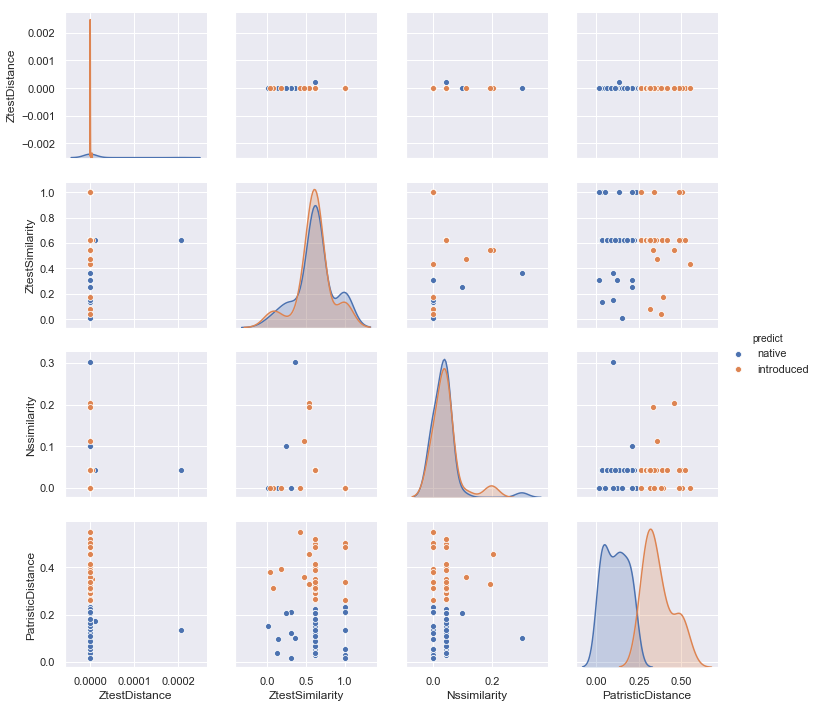

In [15]:
# create graph to show training clusters
print("generating training graph...")
kmeans_graph(
    data_known[best_features],
    metadata_known,
    "md_cluster_training",
    weights=1/metadata_known["N"])

In [17]:
# create kmeans on all data using selected features
print("classifying all data...")
cluster = create_kmeans(
    data_norm[best_features],
    k=metadata["Status"].nunique(),
    weights=1 / metadata["N"])
predict = get_predict(cluster, metadata)

classifying all data...


In [20]:
print("saving new output...")
df = pd.concat([metadata, predict, data], axis=1)
try:
    df.to_csv("{}".format(args[2]))
except KeyError:
    df.to_csv("output/output.csv".format(args[2]))
# change data in frame to be useable for graph


saving new output...


In [22]:
del df

df = pd.concat([data_norm[best_features], predict], axis=1)

generating final graph...
...done!


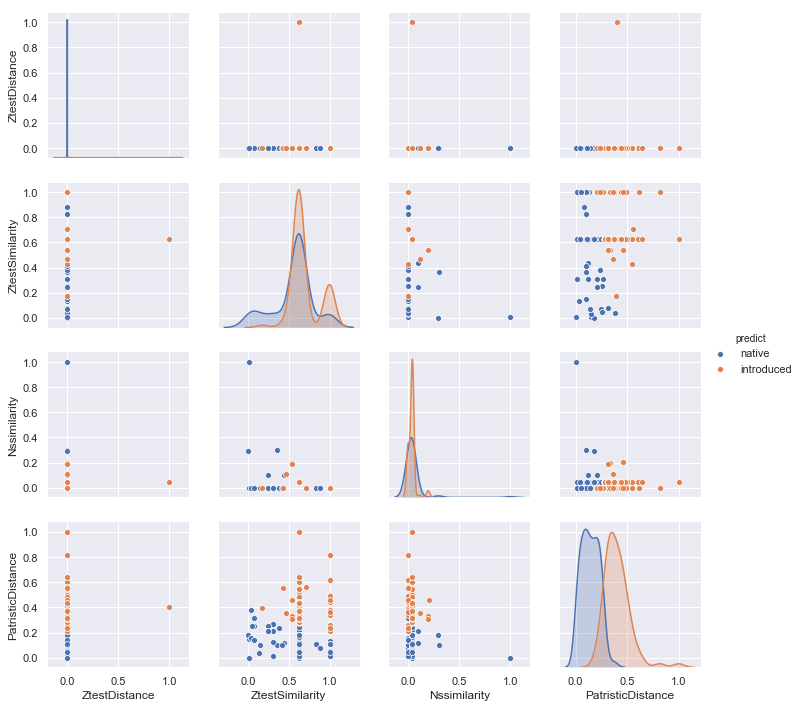

In [25]:
print("generating final graph...")
out = sns.pairplot(
    data=df,
    vars=df.columns[0:data_norm[best_features].shape[1]],
    hue="predict"
)
out.savefig("plots/{}.png".format("md_cluster_inc_unknown"))

print("...done!")